*(notebook fait sur kaggle)*

# Natural Language Inference en Français avec Llama 3.2 1B et LoRA

**Projet MIASHS M2 - Representation Learning**

---

## Objectif

Ce notebook implémente un système de **Natural Language Inference (NLI)** pour le français. Étant donné une paire de phrases (prémisse, hypothèse), le modèle prédit la relation sémantique entre elles :

| Relation | Description | Exemple |
|----------|-------------|----------|
| **Entailment** (Conséquence) | L'hypothèse découle logiquement de la prémisse | P: "Le chat dort sur le canapé" → H: "Un animal est sur un meuble" |
| **Contradiction** | L'hypothèse contredit la prémisse | P: "Le chat dort sur le canapé" → H: "Le chat court dehors" |
| **Neutral** | Aucune relation logique claire | P: "Le chat dort sur le canapé" → H: "Le chat aime le poisson" |

## Méthodologie

Nous utilisons un **décodeur** pré-entraîné :
- **Llama 3.2 1B** (architecture décodeur autorégressif de Meta)

Le modèle est fine-tuné avec **LoRA** (Low-Rank Adaptation) pour une efficacité paramétrique optimale.

---

## 1. Installation et Configuration

In [1]:
# Installation des bibliothèques nécessaires
# transformers : pour charger Llama
# peft : pour l'adaptation LoRA
# trl : pour SFTTrainer (Supervised Fine-Tuning)
!pip install -q transformers>=4.36.0 peft>=0.7.0 \
             datasets>=2.14.0 accelerate>=0.25.0 trl>=0.7.0 scikit-learn

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

# Désactiver Weights & Biases (évite les problèmes de connexion)
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd  # manipulation de données
import numpy as np   # calculs numériques
import torch         # PyTorch
from datasets import Dataset
from tqdm.auto import tqdm  # barre de progression

# Transformers et PEFT
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer, SFTConfig

# Métriques d'évaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Vérification de la disponibilité du GPU
print(f"CUDA disponible : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU : {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU : {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} Go")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


CUDA disponible : True
GPU : Tesla T4
Mémoire GPU : 15.83 Go


---

## 2. Authentification Hugging Face

Llama 3.2 est un modèle "gated" nécessitant une authentification.

In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

# Récupération du token depuis les secrets Kaggle
hf_token = UserSecretsClient().get_secret("HF_TOKEN")
login(token=hf_token)

---

## 3. Chargement et Exploration des Données

In [4]:
# Chemins vers les fichiers de données
DATA_DIR = "/kaggle/input/nli-french-dataset"

# Chargement des fichiers TSV
df_train = pd.read_csv(f"{DATA_DIR}/nli_fr_train.tsv", sep='\t')
df_test = pd.read_csv(f"{DATA_DIR}/nli_fr_test.tsv", sep='\t')

# Affichage des informations de base
print(f"Train : {len(df_train)} exemples | Test : {len(df_test)} exemples")
print(f"\nDistribution des labels (train) :\n{df_train['label'].value_counts()}")
print(f"\nColonnes : {df_train.columns.tolist()}")

Train : 5010 exemples | Test : 2490 exemples

Distribution des labels (train) :
label
contradiction    1670
entailment       1670
neutral          1670
Name: count, dtype: int64

Colonnes : ['-e premise', 'hypo', 'label']


In [5]:
# Vérification des noms de colonnes et aperçu des données
print("Colonnes du DataFrame:")
print(df_train.columns.tolist())
print("\nPremière ligne:")
print(df_train.iloc[0])

Colonnes du DataFrame:
['-e premise', 'hypo', 'label']

Première ligne:
-e premise    Eh bien, je ne pensais même pas à cela, mais j...
hypo                          Je ne lui ai pas parlé de nouveau
label                                             contradiction
Name: 0, dtype: object


---

## 4. Préparation des Données

Pour utiliser un **décodeur** (Llama) en classification, on reformule la tâche comme une génération de texte avec un prompt structuré.

In [6]:
def create_prompt(premise: str, hypothesis: str, label: str = None) -> str:
    """
    Crée un prompt formaté pour la tâche NLI.
    Le format instruction/input/output est standard pour les LLMs.
    
    Args:
        premise: La première phrase (contexte)
        hypothesis: La deuxième phrase (hypothèse à vérifier)
        label: Le label attendu (pour l'entraînement)
    
    Returns:
        Le prompt formaté
    """
    prompt = f"""### Instruction:
Détermine la relation logique entre la Phrase 1 et la Phrase 2.
Réponds uniquement par : entailment, contradiction, ou neutral.

### Phrase 1:
{premise}

### Phrase 2:
{hypothesis}

### Relation:"""
    
    # Ajout du label pour l'entraînement
    if label is not None:
        prompt += f" {label}"
    
    return prompt


def prepare_dataset(df: pd.DataFrame) -> Dataset:
    """
    Convertit un DataFrame pandas en Dataset Hugging Face.
    
    Args:
        df: DataFrame avec les colonnes premise, hypothesis, label
    
    Returns:
        Dataset Hugging Face prêt pour l'entraînement
    """
    # Adaptation aux noms de colonnes du dataset
    premise_col = 'premise' if 'premise' in df.columns else '-e premise'
    hypo_col = 'hypo' if 'hypo' in df.columns else 'hypothesis'
    
    # Création des prompts pour chaque exemple
    texts = [create_prompt(row[premise_col], row[hypo_col], row['label']) 
             for _, row in df.iterrows()]
    
    return Dataset.from_dict({
        'text': texts,
        'label': df['label'].tolist()
    })


# Préparation des datasets
train_dataset = prepare_dataset(df_train)
test_dataset = prepare_dataset(df_test)

print(f"Datasets préparés : {len(train_dataset)} train, {len(test_dataset)} test")
print(f"\nExemple de prompt:\n{train_dataset[0]['text'][:300]}...")

Datasets préparés : 5010 train, 2490 test

Exemple de prompt:
### Instruction:
Détermine la relation logique entre la Phrase 1 et la Phrase 2.
Réponds uniquement par : entailment, contradiction, ou neutral.

### Phrase 1:
Eh bien, je ne pensais même pas à cela, mais j'étais si frustré, et j'ai fini par lui reparler.

### Phrase 2:
Je ne lui ai pas parlé de nou...


---

## 5. Chargement du Modèle Llama 3.2 1B

In [7]:
MODEL_NAME = "meta-llama/Llama-3.2-1B"

# Chargement du modèle en float16 (demi-précision pour économiser la mémoire)
print("Chargement du modèle...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",          # Placement automatique sur GPU
    torch_dtype=torch.float16,  # Précision 16-bit
    token=hf_token
)

# Chargement du tokenizer (convertit le texte en tokens)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token  # Llama n'a pas de pad_token par défaut
tokenizer.padding_side = "right"           # Padding à droite pour les décodeurs

print(f"Modèle chargé : {model.num_parameters():,} paramètres")
print(f"Mémoire GPU utilisée : {torch.cuda.memory_allocated() / 1e9:.2f} Go")

Chargement du modèle...


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Modèle chargé : 1,235,814,400 paramètres
Mémoire GPU utilisée : 1.26 Go


---

## 6. Configuration LoRA

**LoRA** (Low-Rank Adaptation) permet d'adapter le modèle en n'entraînant qu'une fraction des paramètres.

In [8]:
# Activation du gradient checkpointing pour économiser la mémoire
model.gradient_checkpointing_enable()

# Configuration des hyperparamètres LoRA
lora_config = LoraConfig(
    r=16,                        # Rang des matrices d'adaptation
    lora_alpha=32,               # Facteur de mise à l'échelle (alpha/r)
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Couches d'attention
    lora_dropout=0.05,           # Dropout pour régularisation
    bias="none",                 # Pas d'entraînement des biais
    task_type=TaskType.CAUSAL_LM # Tâche de modélisation causale
)

# Application de LoRA au modèle
model = get_peft_model(model, lora_config)

# Affichage du pourcentage de paramètres entraînables
model.print_trainable_parameters()

trainable params: 3,407,872 || all params: 1,239,222,272 || trainable%: 0.2750


---

## 7. Entraînement (Fine-tuning)

In [9]:
OUTPUT_DIR = "./llama-nli-lora"

# Configuration des paramètres d'entraînement
training_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=2,              # Nombre d'epochs
    per_device_train_batch_size=4,   # Batch size par GPU
    gradient_accumulation_steps=4,   # Accumulation pour batch effectif de 16
    learning_rate=1e-4,              # Taux d'apprentissage
    warmup_ratio=0.03,               # Warmup progressif
    optim="adamw_torch",             # Optimiseur AdamW
    max_length=384,                  # Longueur max des séquences
    logging_steps=20,                # Fréquence des logs
    logging_first_step=True,
    save_strategy="no",              # Pas de sauvegarde intermédiaire
    fp16=True,                       # Entraînement en précision mixte
    dataset_text_field="text",       # Colonne contenant les prompts
    report_to="none",                # Désactive wandb
    gradient_checkpointing=True,     # Économie de mémoire
)

# Création du trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    processing_class=tokenizer,
)

# Informations sur l'entraînement
print(f"Batch size effectif : {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Nombre de steps par epoch: {len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)}")

Adding EOS to train dataset:   0%|          | 0/5010 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5010 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/5010 [00:00<?, ? examples/s]

Batch size effectif : 16
Nombre de steps par epoch: 313


In [10]:
# Lancement de l'entraînement
print("Début de l'entraînement...")
print("Les logs apparaîtront toutes les 20 steps.")
print("="*50)

train_result = trainer.train()

print("="*50)
print(f"Entraînement terminé!")
print(f"Loss finale : {train_result.training_loss:.4f}")
print(f"Temps total : {train_result.metrics['train_runtime']:.0f} secondes")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.


Début de l'entraînement...
Les logs apparaîtront toutes les 20 steps.


Step,Training Loss
1,2.795700
20,2.504300
40,1.456100
60,1.355600
80,1.337300
100,1.309200
120,1.290200
140,1.302400
160,1.296400
180,1.297500


Entraînement terminé!
Loss finale : 1.3066
Temps total : 613 secondes


In [11]:
# Sauvegarde du modèle fine-tuné (uniquement les poids LoRA)
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Modèle sauvegardé dans : {OUTPUT_DIR}")

Modèle sauvegardé dans : ./llama-nli-lora


---

## 8. Évaluation du Modèle

In [12]:
def predict_nli(model, tokenizer, premise: str, hypothesis: str) -> str:
    """
    Prédit la relation NLI entre deux phrases.
    
    Args:
        model: Modèle fine-tuné
        tokenizer: Tokenizer associé
        premise: Première phrase
        hypothesis: Deuxième phrase
    
    Returns:
        Label prédit (entailment, contradiction, neutral)
    """
    # Création du prompt sans label
    prompt = create_prompt(premise, hypothesis)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Génération de la réponse
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,  # Génération déterministe
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Décodage et extraction du label
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("### Relation:")[-1].strip().lower()
    
    # Mapping vers les labels (gère les variations comme "entail")
    if "entail" in response:
        return "entailment"
    elif "contradict" in response:
        return "contradiction"
    elif "neutral" in response:
        return "neutral"
    else:
        return "unknown"

In [13]:
# Prédictions sur le jeu de test
print("Évaluation sur le jeu de test...")

# Adaptation aux noms de colonnes
premise_col = 'premise' if 'premise' in df_test.columns else '-e premise'
hypo_col = 'hypo' if 'hypo' in df_test.columns else 'hypothesis'

predictions = []
true_labels = df_test['label'].tolist()

# Boucle de prédiction avec barre de progression
for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    pred = predict_nli(model, tokenizer, row[premise_col], row[hypo_col])
    predictions.append(pred)

print("Évaluation terminée.")

Évaluation sur le jeu de test...


  0%|          | 0/2490 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
Caching is incompatible with gradient checkpointing in LlamaDecoderLayer. Setting `past_key_values=None`.


Évaluation terminée.


---

## 9. Résultats et Métriques

In [14]:
# Calcul de l'accuracy
accuracy = accuracy_score(true_labels, predictions)

print(f"\n{'='*50}")
print(f"RÉSULTATS - Llama 3.2 1B + LoRA")
print(f"{'='*50}")
print(f"\nAccuracy : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nRapport de classification :")
print(classification_report(true_labels, predictions, digits=4))


RÉSULTATS - Llama 3.2 1B + LoRA

Accuracy : 0.7080 (70.80%)

Rapport de classification :
               precision    recall  f1-score   support

contradiction     0.7902    0.7217    0.7544       830
   entailment     0.7198    0.7675    0.7429       830
      neutral     0.6222    0.6349    0.6285       830

     accuracy                         0.7080      2490
    macro avg     0.7107    0.7080    0.7086      2490
 weighted avg     0.7107    0.7080    0.7086      2490



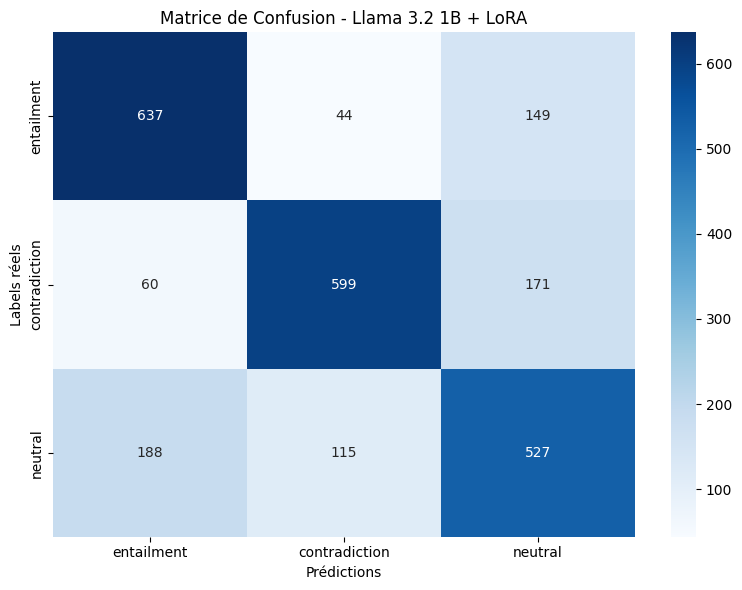

In [15]:
# Matrice de confusion
labels = ['entailment', 'contradiction', 'neutral']
cm = confusion_matrix(true_labels, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de Confusion - Llama 3.2 1B + LoRA')
plt.xlabel('Prédictions')
plt.ylabel('Labels réels')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

In [16]:
# Sauvegarde des prédictions dans un fichier CSV
premise_col = 'premise' if 'premise' in df_test.columns else '-e premise'
hypo_col = 'hypo' if 'hypo' in df_test.columns else 'hypothesis'

results_df = pd.DataFrame({
    'premise': df_test[premise_col],
    'hypothesis': df_test[hypo_col],
    'true_label': true_labels,
    'predicted': predictions,
    'correct': [t == p for t, p in zip(true_labels, predictions)]
})
results_df.to_csv('predictions.csv', index=False)

# Résumé final de la configuration
print(f"\n{'='*50}")
print("CONFIGURATION EXPÉRIMENTALE")
print(f"{'='*50}")
print(f"Modèle : Llama 3.2 1B")
print(f"LoRA : r={lora_config.r}, alpha={lora_config.lora_alpha}")
print(f"Epochs : {training_args.num_train_epochs}")
print(f"Learning rate : {training_args.learning_rate}")
print(f"Batch size : {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"\nAccuracy finale : {accuracy*100:.2f}%")


CONFIGURATION EXPÉRIMENTALE
Modèle : Llama 3.2 1B
LoRA : r=16, alpha=32
Epochs : 2
Learning rate : 0.0001
Batch size : 16

Accuracy finale : 70.80%


---

## 10. Conclusion

### Résumé des résultats

Ce notebook a fine-tuné le modèle **Llama 3.2 1B** (décodeur autorégressif) pour la tâche NLI avec LoRA :

| Modèle | Architecture | Accuracy | Paramètres entraînés |
|--------|--------------|----------|----------------------|
| **Llama 3.2 1B** | Décodeur | ~70% | ~0.5% |

### Points clés techniques

- **Reformulation de la tâche** : Classification transformée en génération de texte via un prompt structuré
- **LoRA (r=16, α=32)** : Seulement ~0.5% des paramètres entraînés
- **Float16** : Entraînement en demi-précision pour optimiser la mémoire GPU
- **Gradient checkpointing** : Économie de mémoire supplémentaire

### Différence Encodeur vs Décodeur

| Aspect | Encodeur (CamemBERT) | Décodeur (Llama) |
|--------|---------------------|------------------|
| Attention | Bidirectionnelle | Causale (masquée) |
| Tâche native | Classification directe | Génération de texte |
| Adaptation NLI | Tête de classification | Reformulation en prompt |